# Fine-Tuning for Image Classification on CIFAR-10
This notebook demonstrates transfer learning and fine-tuning for image classification using CIFAR-10.

### Steps:
1. Define a CIFAR-10 wrapper that removes classes.
2. Train a small CNN on the modified dataset.
3. Fine-tune the CNN on the full CIFAR-10 dataset.
4. Fine-tune a pretrained ResNet model on CIFAR-10.


In [6]:
import torch
from tqdm import tqdm, trange  # To show the progress bar
import matplotlib.pyplot as plt

## Step 1: Define a Wrapper for CIFAR-10
We will modify the CIFAR-10 dataset by removing one class. As a first step (down)load the CIFAR10 dataset and plot some samples.

50000


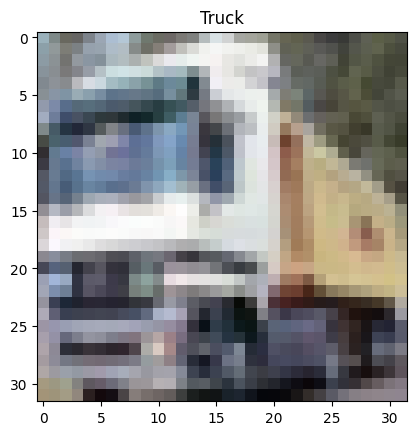

In [14]:
from torchvision.datasets import CIFAR10

cifar10_classes = [
    "Airplane",   # 0
    "Automobile", # 1
    "Bird",       # 2
    "Cat",        # 3
    "Deer",       # 4
    "Dog",        # 5
    "Frog",       # 6
    "Horse",      # 7
    "Ship",       # 8
    "Truck"       # 9
]


cifar10_ds = CIFAR10('data',train=True,download=True)


print(len(cifar10_ds))

img, label = cifar10_ds[1]

#plot some samples
plt.title(cifar10_classes[label])
plt.imshow(img)
plt.show()




Let us define a `CIFAR10WithoutClasses` class that inherits from `CIFAR10` and removes selected classes of samples. 

**Hint:** `CIFAR10.targets` contains the list of labels, meaning that `CIFAR10.targets[k]` is the label of the k-th sample

In [15]:
class CIFAR10WithoutClasses(CIFAR10):
    def __init__(self, root, train=True, download=True, transform=None, removed_classes=[]):
        super().__init__(root=root, train=train, download=download, transform=transform)
        self.removed_classes = removed_classes

        self.indices = [i for i, label in enumerate(self.targets) if label not in removed_classes]

        
        # Create a label mapping
        self.label_map = {label: new_label for new_label, label in enumerate(sorted(set(self.targets) - set(removed_classes)))}

    def __getitem__(self, index):

        # call super().__getitem__() in some way

        orig_index = self.indices[index]

        img, label = super().__getitem__(orig_index)

        new_label = self.label_map[label]

        return img, new_label

    def __len__(self):
        return len(self.indices)

Define the transforms. Pick some random transformation of you choice (rotations, flips, crops).

In [18]:
import torchvision.transforms as transforms

# compute mean and std
means = cifar10_ds.data.mean(axis=(0, 1, 2)) / 255
stds = cifar10_ds.data.std(axis=(0, 1, 2)) / 255

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=means,std=stds)
])

# Data Augmentation for Training Set
train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28),
    test_transform,
])

Define datasets and split train in train and val with a 80-20 split using `torch.utils.data.random_split`.

In [20]:
removed_classes = [3,8]

full_trainset = CIFAR10WithoutClasses(root='./data', train=True, download=True, transform=train_transform, removed_classes=removed_classes)
test_set = CIFAR10WithoutClasses(root='./data', train=False, download=True, transform=test_transform, removed_classes=removed_classes)

val_size = int(len(full_trainset) * 0.2)

train_set, val_set = torch.utils.data.random_split(full_trainset,[len(full_trainset) - val_size ,val_size])


print(f"Training Samples: {len(train_set)}, Validation Samples: {len(val_set)}, Test Samples: {len(test_set)}")


Training Samples: 32000, Validation Samples: 8000, Test Samples: 8000


Define dataloaders with batch_size of 64.

In [23]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# DataLoaders
train_loader = DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_set,batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE)

Implement a function that shows a batch of data

In [21]:
import matplotlib.pyplot as plt
import torchvision.utils

# Function to display a grid of images from the test set
def show_batch(dataloader,title=''):
    images, _ =  next(iter(dataloader)) # Get a batch of test images

    grid_img = torchvision.utils.make_grid(images, nrow=8, padding=1, normalize=True)

    # Convert to NumPy and plot
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.axis("off")
    plt.title(title)
    plt.show()

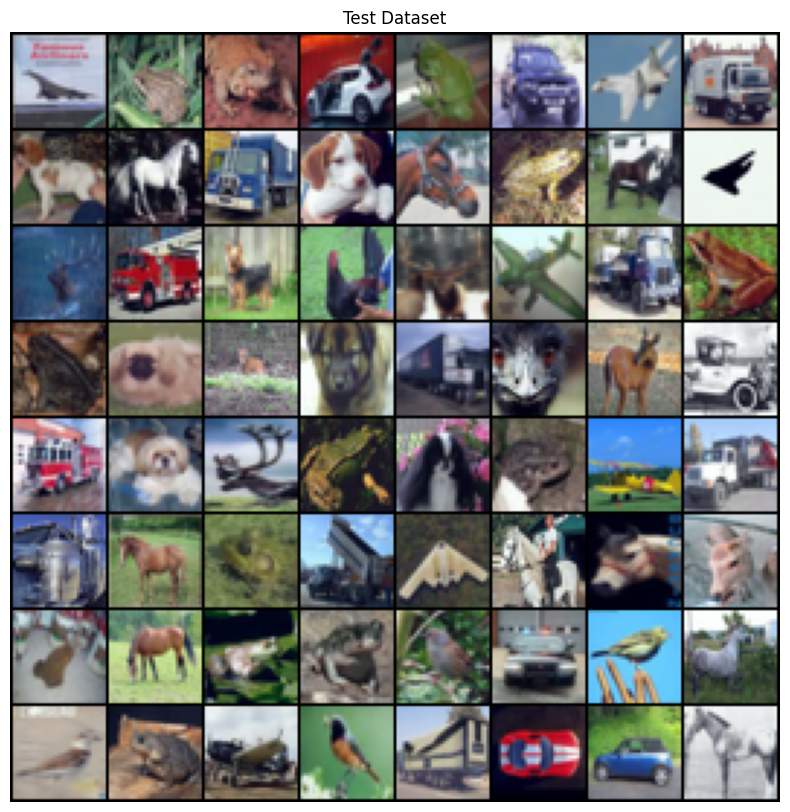

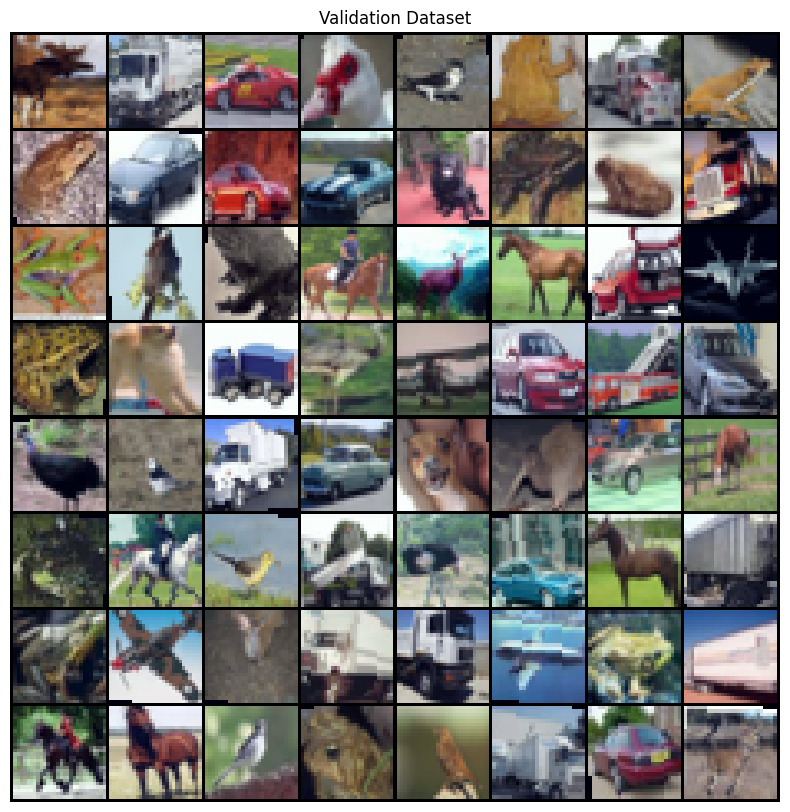

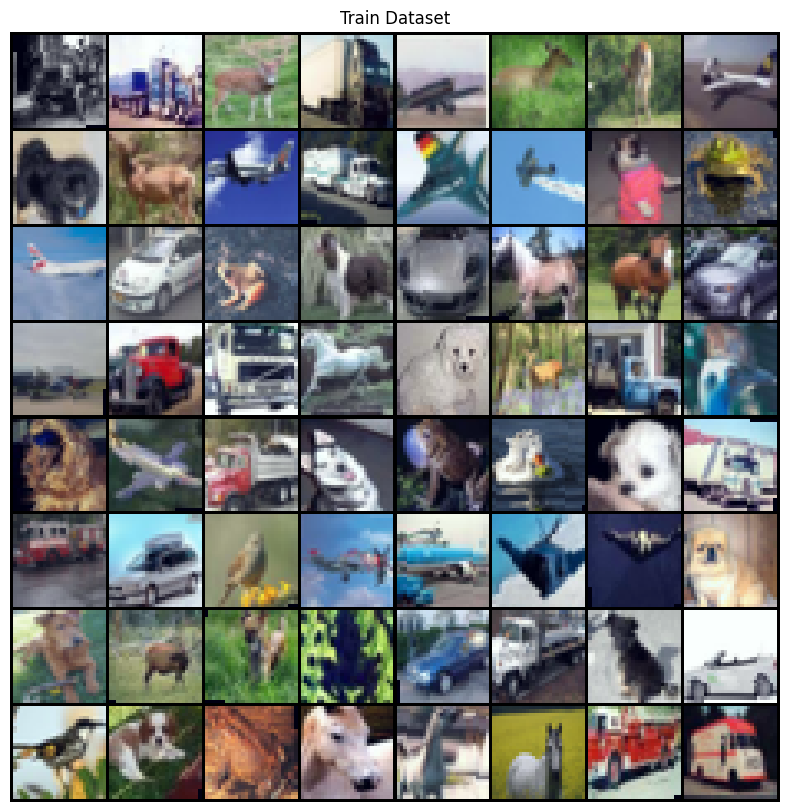

In [24]:
show_batch(test_loader, "Test Dataset")
show_batch(val_loader, "Validation Dataset")
show_batch(train_loader, "Train Dataset")


## Step 2: Define and Train a Small CNN
We will define a simple convolutional neural network and train it on the modified dataset.

Here is the code of a function that computes accuracy from the prediction. Is it correct?

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Implement a function `train_epoch` that does trains the model for one epoch. Remember to set the model in training mode. This function should return `epoch_loss` and `epoch_accuracy`.

In [ ]:
def train_epoch(model, data_loader, optimizer, loss_fn, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()
    # implement it

    for (x,y) in data_loader:

        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)

        loss = loss_fn(y,y_pred)
        epoch_loss += loss.item()

        # compute accuracy and possibly other metrics
        acc = calculate_accuracy(y_pred, y)
        epoch_acc += acc.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)



Implement a function `eval_epoch` that does evaluates the model for one epoch. Remember to set the model in evaluation mode (and to disable gradient tracking). This function should return `epoch_loss` and `epoch_accuracy`.

In [ ]:
def eval_epoch(model, data_loader, loss_fn, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.inference_mode(): # disable gradient tracking

        for (x, y) in tqdm(data_loader, desc="Evaluating", leave=False): # load batch of data

            # push batch to device
            x = x.to(device)
            y = y.to(device)

            # compute predictions
            y_pred = model(x)

            # compute metrics
            loss = loss_fn(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    # implement it

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

Define a function `train_and_test` that takes the model, parameters to optimize, data loaders and trains the model for `num_epochs` epochs with `CrossEntropyLoss` and `Adam` optimizer with weight decay. It should also save the model with highest validation accuracy / lowest validation loss and reload it to test it.

In [ ]:
import time

def train_and_test(model, parameters, train_loader, val_loader, test_loader, device, num_epochs=5, file_name_suffix = ''):
    best_valid_loss = float('inf')
    best_valid_acc = 0
    best_valid_loss_epoch = 0

    suffix = ('_' + file_name_suffix) if file_name_suffix else ''
    best_model_file_name = f'best_model{suffix}.pth'

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(parameters, lr=0.001, weight_decay=1e-4), 

    model.to(device)

    # evaluate it to assert that the forward is ok
    _, _ = eval_epoch(model, test_loader, loss_fn, device)
    
    # Loop over the epochs
    for epoch in range(num_epochs):
        start_time = time.monotonic()  # Track the start time for each epoch

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)

        # Validation phase
        valid_loss, valid_acc = eval_epoch(model, val_loader, loss_fn, device)

        # Save the best model based on validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_valid_loss_epoch = epoch
            best_valid_acc = valid_acc
            
            torch.save(model.state_dict(), best_model_file_name)

        # Time taken for the epoch
        epoch_time = time.monotonic() - start_time

        # Print the results of the current epoch
        print(f'Epoch: {epoch+1:02} | Time: {epoch_time:.2f}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

    print(f'Saved model from epoch {best_valid_loss_epoch} (val loss: {best_valid_loss:.3f} | val acc: {best_valid_acc*100:.2f}%)')

    # load best performing model
    model.load_state_dict(torch.load(best_model_file_name))

    # evaluate it on the test dataset
    test_loss, test_acc = eval_epoch(model, test_loader, loss_fn, device)

    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

    return model



### The model

Define a SimpleCNN model with 4 Convolutional Layers, an `AdaptiveAvgPool2d` and 2 dense classification layer in the end.

Implement a `ConvLayer` function that gives a convolutional layer made of:
- convolution with `padding=1`
- batch normalization
- ReLU
- MaxPool

Implement a classifier made of 2 dense layers with dropout.

In the forward remember to flatten before the classifier

In [ ]:
import torch.nn as nn

def ConvLayer(in_channels, out_channels, kernel_size=3, pool_size=2):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
    )

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Feature extraction part (4 ConvLayers)
        self.feature_extraction = nn.Sequential(
            ConvLayer(3, 32),  # 3x32x32 → 32x16x16
            ConvLayer(32, 64),  # 32x16x16 → 64x8x8
            ConvLayer(64, 128),  # 64x8x8 → 128x4x4
            ConvLayer(128, 256)  # 128x4x4 → 256x2x2
        )

        # Global Average Pooling (output size: 256x1x1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Smaller classifier with a lightweight fully connected layer
        self.classifier = 

    def forward(self, x):
        
        return x


# Example usage: Create model for 9-class classification
model = SimpleCNN(num_classes=9)
print(model)

This is a function that counts the number of total and trainable parameters 

In [ ]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {
        "total": total,
        "trainable": trainable,
        }

In [ ]:
print(count_parameters(model))
print(count_parameters(model.feature_extraction))
print(count_parameters(model.classifier))

Choose the device we want to use

In [ ]:
device_str = "cpu"
if torch.cuda.is_available():
  # Cuda / Nvidia
  device_str = "cuda"
elif torch.backends.mps.is_built():
  # Metal / Apple Silicon
  device_str = "mps"

device = torch.device(device_str)
print(f'Selected device: "{device}"')

In [ ]:
EPOCHS = 20

# redefine this here so we can re-execute this
model = SimpleCNN(num_classes=9)

train_and_test(model,
               model.parameters(),
               train_loader,
               val_loader,
               test_loader,
               device,
               num_epochs=EPOCHS
           )

## Step 3: Fine-Tune the CNN on Full CIFAR-10
Now, we fine-tune the trained CNN on the full CIFAR-10 dataset.

In [ ]:
full_train_dataset = CIFAR10(root="./data", train=True, transform=train_transform, download=True)
full_test_dataset = CIFAR10(root="./data", train=False, transform=test_transform, download=True)

# Split train dataset into train & validation (80-20 split)
full_train_size = int(0.8 * len(full_train_dataset))
full_val_size = len(full_train_dataset) - full_train_size
full_train_dataset, full_val_dataset = torch.data.utils.random_split(full_train_dataset, [full_train_size, full_val_size])

# Define data loaders
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
full_val_loader = DataLoader(full_val_dataset, batch_size=BATCH_SIZE)
full_test_loader = DataLoader(full_test_dataset, batch_size=BATCH_SIZE)

## Fine Tuning

Modify the model by allowing it to classify 10 classes

In [ ]:
import copy

model_c10 = copy.deepcopy(model)



Freeze the convolutional part

In [ ]:
model_c10_ft = copy.deepcopy(model_c10)



print(count_parameters(model_c10_ft))
print(count_parameters(model_c10_ft.feature_extraction))
print(count_parameters(model_c10_ft.classifier))

Train the model

In [ ]:
train_and_test(model_c10_ft,
               # parameters
               full_train_loader,
               full_val_loader,
               full_test_loader,    
               device,
               num_epochs=5,
               file_name_suffix='cifar10_fine_tuned')


Train the whole model

In [ ]:
model_c10_full = copy.deepcopy(model_c10)

print(count_parameters(model_c10_full))

train_and_test(model_c10_full,
               model_c10_full.parameters(),
               full_train_loader,
               full_val_loader,
               full_test_loader,
               device,
               num_epochs=5,
               file_name_suffix='cifar10_full')

## Step 4: Fine-Tune a Pretrained ResNet
We now load a pretrained ResNet model and fine-tune it on CIFAR-10.

In [ ]:

import torchvision.models as models

# Load pretrained ResNet model
resnet18 = models.resnet18(pretrained=True)


for param in resnet18.parameters():
    param.requires_grad = False  # No gradients for the feature extractor

resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)  # Adjust final layer for 10 classes
resnet18.to(device)

for param in resnet18.layer4.parameters():
    param.requires_grad = True


print(resnet18)

print(count_parameters(resnet18))


In [ ]:
train_and_test(resnet18,
               resnet18.fc.parameters(),
               full_train_loader,
               full_val_loader,
               full_test_loader,
               device,
               num_epochs=20,
               file_name_suffix='resnet_cifar10_fine')